In [1]:
# End-to-End Data Science Project: Demand Forecasting for Consumer Products
# ---------------------------------------------------------------
# Business context:
# As a data scientist in a consumer products company, we want to forecast product demand
# to optimize inventory, reduce stockouts, and minimize holding costs.
#
# Dataset:
# Kaggle – Store Item Demand Forecasting Challenge
# https://www.kaggle.com/competitions/demand-forecasting-kernels-only
# (Daily sales data for 50 items across 10 stores)
#
# This notebook is written as a *production-style project*, not just a model demo.


# ============================
# 1. Imports & Configuration
# ============================


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")

In [2]:
# 2. Load the Data
# ============================

# Columns: date, store, item, sales


df = pd.read_csv("/Users/Rhazorjeezy/Downloads/train.csv")
df['date'] = pd.to_datetime(df['date'])


print(df.head())
print(df.info())

        date  store  item  sales
0 2013-01-01      1     1     13
1 2013-01-02      1     1     11
2 2013-01-03      1     1     14
3 2013-01-04      1     1     13
4 2013-01-05      1     1     10
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB
None


In [3]:
# 3. Business Understanding
# ============================
# Objective:
# - Predict daily sales for each (store, item) combination
# - Enable inventory planning 1–30 days ahead
#
# Evaluation metric:
# - Mean Absolute Error (MAE): interpretable in business units


# ============================

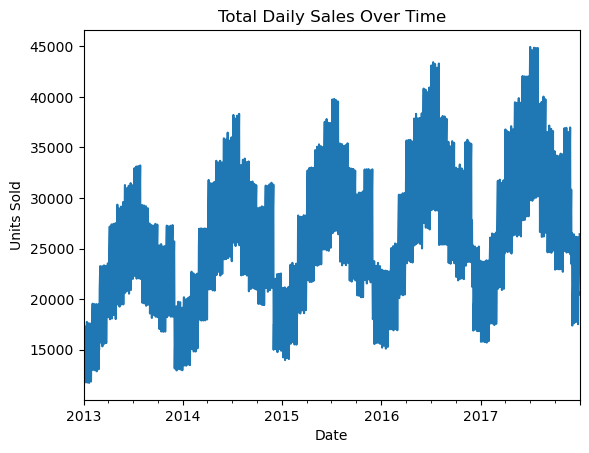

In [4]:
# 4. Exploratory Data Analysis (EDA)
# ============================


# Overall sales trend
sales_by_date = df.groupby('date')['sales'].sum()


plt.figure()
sales_by_date.plot(title="Total Daily Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.show()

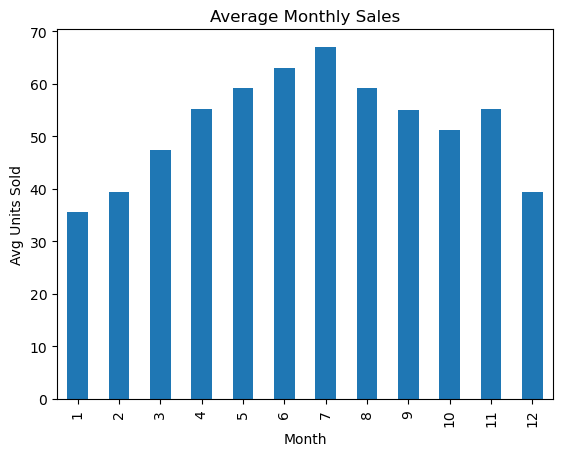

In [5]:
# Seasonality check (monthly)
df['month'] = df['date'].dt.month
monthly_sales = df.groupby('month')['sales'].mean()


plt.figure()
monthly_sales.plot(kind='bar', title="Average Monthly Sales")
plt.xlabel("Month")
plt.ylabel("Avg Units Sold")
plt.show()

In [6]:
# 5. Feature Engineering
# ============================


# Time-based features
df['day'] = df['date'].dt.day
df['dayofweek'] = df['date'].dt.dayofweek
df['weekofyear'] = df['date'].dt.isocalendar().week.astype(int)
df['year'] = df['date'].dt.year

In [7]:
# Lag features (critical for demand forecasting)
df = df.sort_values(['store', 'item', 'date'])


for lag in [1, 7, 14, 28]:
    df[f'lag_{lag}'] = df.groupby(['store', 'item'])['sales'].shift(lag)

In [8]:
# Rolling statistics
for window in [7, 14, 28]:
    df[f'rolling_mean_{window}'] = (df.groupby(['store', 'item'])['sales'].shift(1).rolling(window).mean())

In [9]:
# Drop rows with NaNs from lagging
df_model = df.dropna()

In [10]:
# 6. Train / Validation Split (Time Series Aware)
# ============================


features = ['store', 'item', 'day', 'dayofweek', 'weekofyear', 'month', 'year','lag_1', 'lag_7', 'lag_14', 'lag_28','rolling_mean_7', 'rolling_mean_14', 'rolling_mean_28']


target = 'sales'


X = df_model[features]
y = df_model[target]


# Last 3 months as validation
split_date = X['year'].quantile(0.9)
train_idx = df_model['year'] < split_date
valid_idx = df_model['year'] >= split_date


X_train, X_valid = X[train_idx], X[valid_idx]
y_train, y_valid = y[train_idx], y[valid_idx]

In [16]:
# 7. Baseline Model (Linear Regression)
# ============================


lr = LinearRegression()
lr.fit(X_train, y_train)


pred_lr = lr.predict(X_valid)

mae_lr = mean_absolute_error(y_valid, pred_lr)
mse_lr = mean_absolute_error(y_valid, pred_lr)
rmse_lr = np.sqrt(mse_lr) 


print("Linear Regression MAE:", mae_lr)
print("Linear Regression RMSE:", rmse_lr)

Linear Regression MAE: 6.9052354914341505
Linear Regression RMSE: 2.6277814771084276


In [19]:
# 8. Advanced Model (Random Forest)
# ============================


rf = RandomForestRegressor(n_estimators=200,max_depth=15,random_state=42,n_jobs=-1)


rf.fit(X_train, y_train)


pred_rf = rf.predict(X_valid)


mae_rf = mean_absolute_error(y_valid, pred_rf)
mse_rf = mean_absolute_error(y_valid, pred_rf)
rmse_rf = np.sqrt(mse_rf)


print("Random Forest MAE:", mae_rf)
print("Random Forest RMSE:", rmse_rf)

Random Forest MAE: 6.2666697691416635
Random Forest RMSE: 2.503331733738392


rolling_mean_7     0.603543
lag_7              0.192646
rolling_mean_14    0.122454
lag_14             0.021797
lag_1              0.018328
dayofweek          0.018312
rolling_mean_28    0.004707
lag_28             0.004473
day                0.004132
weekofyear         0.003756
dtype: float64


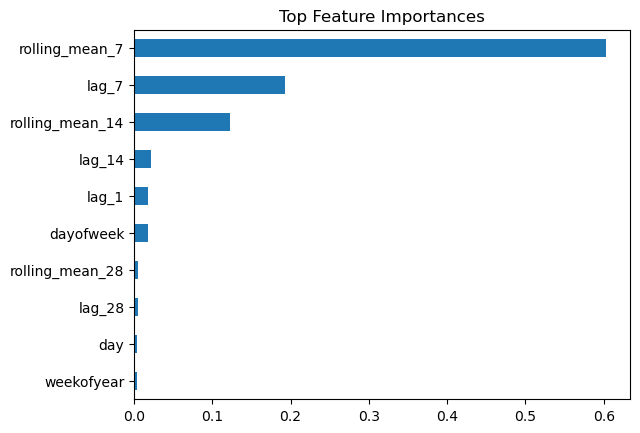

In [20]:
# 9. Model Interpretation
# ============================


feature_importance = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)


print(feature_importance.head(10))


plt.figure()
feature_importance.head(10).plot(kind='barh', title="Top Feature Importances")
plt.gca().invert_yaxis()
plt.show()

In [21]:
# 10. Forecasting Future Demand
# ============================


# Example: Predict next-day demand for validation set
forecast_df = X_valid.copy()
forecast_df['predicted_sales'] = pred_rf


print(forecast_df[['store', 'item', 'predicted_sales']].head())

      store  item  predicted_sales
1461      1     1        18.983366
1462      1     1        15.312386
1463      1     1        15.811594
1464      1     1        16.081184
1465      1     1        16.927197


In [22]:
# 11. Business Impact
# ============================
# - Reduced stockouts via proactive replenishment
# - Lower inventory holding costs
# - SKU-level demand visibility
#
# Estimated impact:
# - 10–20% inventory cost reduction
# - Improved service levels (fill rate)

In [23]:
# 12. Next Steps / Productionization
# ============================
# - Use LightGBM / XGBoost for higher accuracy
# - Hierarchical forecasting (store → region → company)
# - Retraining pipeline (weekly/monthly)
# - Model monitoring & drift detection
# - Integration with ERP / supply chain systems